# Assignment 5

Welcome to the assignment for week 5.

## Task 5: Optical Flow

### Task 5.1: Block Matching

* Implement the block matching method as shown in the lecture
* Take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* Display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

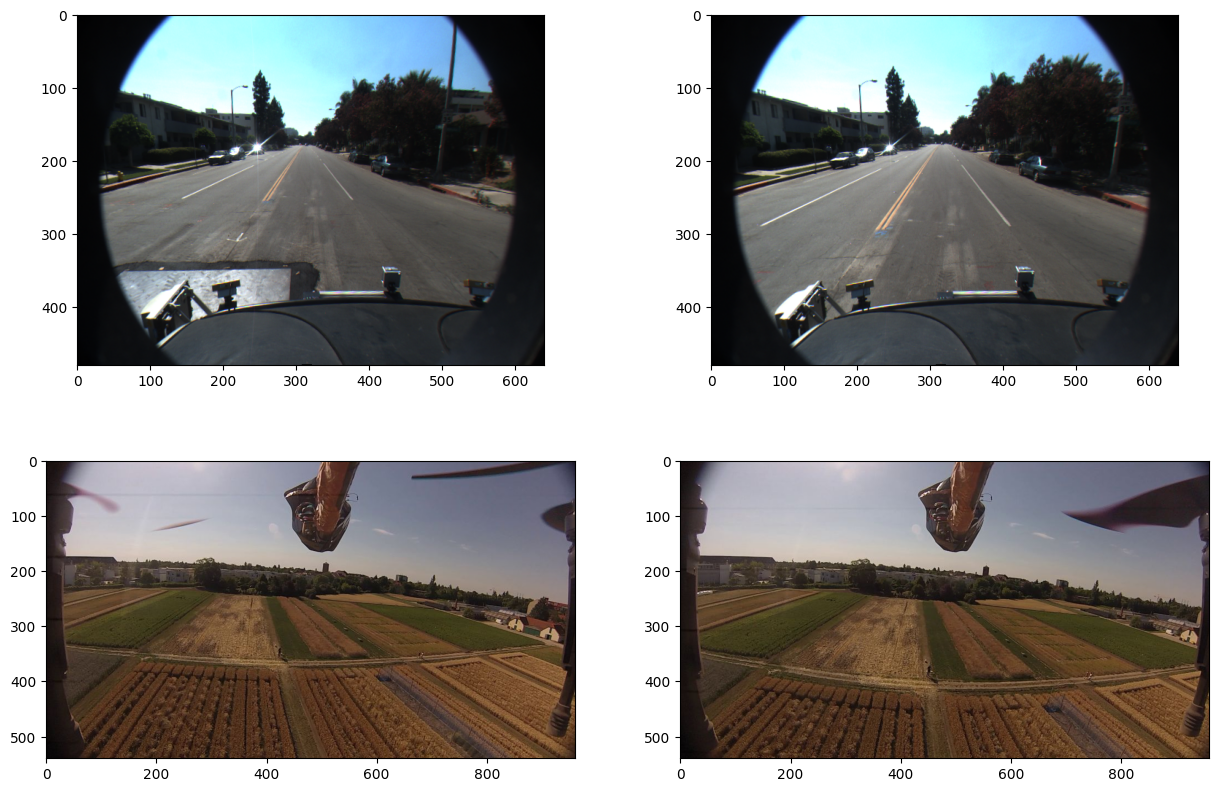

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
import matplotlib.patches as patches

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(lane1)
ax12.imshow(lane2)

ax21.imshow(copter1)
ax22.imshow(copter2)

In [20]:
copter1_gray = color.rgb2gray(copter1)
copter2_gray = color.rgb2gray(copter2)

def ssd(a, b):
    return np.sum((a - b)**2)

def optical_flow(a, b, block_size=20, search_area=21):
    assert a.shape == b.shape
    h,w = a.shape
    flow = np.zeros((h,w, 2))
    for (y,x) in np.ndindex(a.shape):
        if not (0 <= y < y+block_size < h  and 0 <= x < x+block_size < w):
            continue
        block = a[y:y+block_size, x:x+block_size]
        flow[y,x] = max(
            (
                (dy-search_area//2, dx-search_area//2) for dx,dy in np.ndindex(search_area, search_area)
                if (
                    0 <= y+dy-search_area//2 < y+dy-search_area//2+block_size < h  
                    and 0 <= x+dx-search_area//2 < x+dx-search_area//2+block_size < w
                )
            ),
            key=lambda d: ssd(block, b[y+d[0]:y+d[0]+block_size, x+d[1]:x+d[1]+block_size]),
            default=(0,0)
        )
    return flow

flow = optical_flow(copter1_gray, copter2_gray)
print(flow.shape)
maximal_optical_flow = [
    (p, flow[p]) for p in sorted(
        np.ndindex(flow.shape[:2]),
        key=lambda p: np.linalg.norm(flow[p]),
        reverse=True
    )
][:10]
maximal_optical_flow

plt.imshow(copter1)

for (y,x), (dy,dx) in maximal_optical_flow:
    plt.arrow(x, y, dx, dy, color='red', head_width=5)

KeyboardInterrupt: 

### Task 5.2: Harris Corner Detection

* Implement the Harris Corner Detector as discussed in the lecture
* Compute and Plot the Harris Corners for the the two images given at the top of this assignment (**RESULT**)

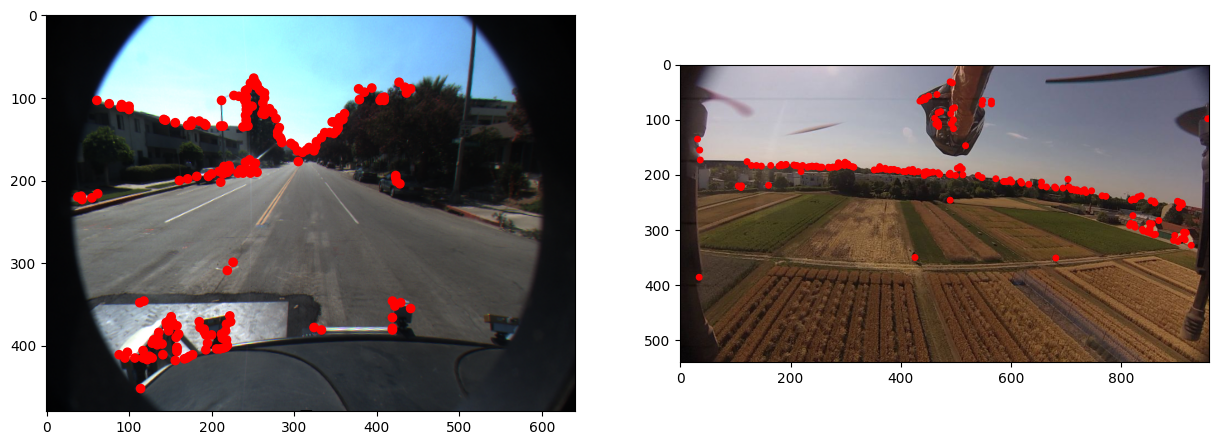

In [30]:
from itertools import combinations_with_replacement
import skimage


def harris_corner_detection(img, sigma=1, k=0.02, treshhold=0.001):
    derivatives = [
        skimage.filters.sobel(img, axis=i, mode="constant") for i in range(img.ndim)
    ]

    # Iy2, Ixy, Ix2
    Arr, Arc, Acc = [
        skimage.filters.gaussian(der0 * der1, sigma=sigma)
        for der0, der1 in combinations_with_replacement(derivatives, 2)
    ]

    det = Arr * Acc - Arc**2
    
    trace = Arr + Acc

    # treshholding + non-maximum suppression
    return feature.corner_peaks(det - k * trace**2, threshold_abs=treshhold)

lane1_corners = harris_corner_detection(color.rgb2gray(lane1))
copter1_corners = harris_corner_detection(copter1_gray)

# print(lane1_corners, copter1_corners)

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(1, 2, 1)
ax12 = plt.subplot(1, 2, 2)

ax11.imshow(lane1)
ax12.imshow(copter1)

for y,x in lane1_corners:
    ax11.add_patch(patches.Circle((x, y), 5, color='red'))

for y,x in copter1_corners:
    ax12.add_patch(patches.Circle((x, y), 5, color='red'))


### Task 5.3: Lucas Kanade

* For the corner images from Task 5.2, track them with Lucas Kanade (feel free to use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* Mark the positions of your Harris Corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the two images given in the beginning of this assignment (**RESULT**)


In [ ]:
from skimage.registration import optical_flow_ilk

def lk(img1, img2):
    return optical_flow_ilk(
        img1, img2, 
    )

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(1, 2, 1)
ax12 = plt.subplot(1, 2, 2)

ax11.imshow(copter1)
ax12.imshow(copter2)

for y,x in lane1_corners:
    ax11.add_patch(patches.Circle((x, y), 5, color='red'))
    

for y,x in copter1_corners:
    ax12.add_patch(patches.Circle((x, y), 5, color='red'))


array([[[-16.191854 , -16.198227 , -16.021769 , ...,   2.0390434,
           2.146834 ,   2.2122102],
        [-16.051752 , -16.151625 , -15.992917 , ...,   2.105495 ,
           2.2032192,   2.270158 ],
        [-14.906101 , -15.382676 , -15.349555 , ...,   2.1319118,
           2.2101152,   2.2771685],
        ...,
        [-10.643455 , -10.641339 , -10.4791975, ...,  10.924356 ,
           9.676503 ,   9.289012 ],
        [-10.751866 , -10.750612 , -10.587681 , ...,  13.002614 ,
          11.50586  ,  10.950935 ],
        [-10.758376 , -10.752313 , -10.587337 , ...,  12.712325 ,
          10.742806 ,  10.130007 ]],

       [[ 16.450659 ,  16.848751 ,  16.939484 , ...,   3.927798 ,
           3.6343684,   4.028738 ],
        [ 16.307938 ,  16.728794 ,  16.824322 , ...,   3.7879996,
           3.4516432,   3.8164003],
        [ 16.271492 ,  16.707165 ,  16.806871 , ...,   3.644227 ,
           3.2404416,   3.5436196],
        ...,
        [-11.919711 ,  -9.891854 ,  -7.557598 , ...,  

## Congratz, you made it! :)